# Trabajo Final Aprendizaje de Máquinas - Marino, Musciano, Uribe

La medición precisa de la grasa corporal es inconveniente/costosa y es deseable disponer de métodos sencillos para estimar la grasa corporal que no sean inconvenientes/costosos. Con este dataset de 252 hombres se busca predecir el porcentaje de grasa corporal (BodyFat) determinado mediante el cálculo de la densidad del cuerpo (Density), en base a diferentes mediciones corporales.

Link al dataset: https://www.kaggle.com/datasets/fedesoriano/body-fat-prediction-dataset/

## Propuesta de investigación

La medición precisa de la grasa corporal es inconveniente/costosa y es deseable disponer de métodos sencillos para estimar la grasa corporal que no sean inconvenientes/costosos. Con este dataset de 252 hombres se busca predecir el porcentaje de grasa corporal (BodyFat) determinado mediante el cálculo de la densidad del cuerpo (Density), en base a diferentes mediciones corporales.

Link al dataset: https://www.kaggle.com/datasets/fedesoriano/body-fat-prediction-dataset/


## Análisis del Dataset

In [122]:
# Importamos librerías básicas
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns

# Prefiero los colores oscuros en los gráficos
sns.set(rc={
    'axes.facecolor': 'black',
    'figure.facecolor': 'black',
    'axes.labelcolor': 'white',
    'xtick.color': 'cyan',
    'ytick.color': 'white',
    'axes.titlecolor': 'white'
})


df = pd.read_csv("data/bodyfat.csv")

# Pasamos el peso a kilogramos y la altura a metros para mayor legibilidad
df['Weight'] = df['Weight'] * 0.453592
df['Height'] = df['Height'] * 0.0254

# Nos deshacemos de la columna Density (está estrechamente relacionada con BodyFat
# a través de la ecuación de Siri ( %Body Fat = (495 / Body Density) - 450 ) como dice 
# el diccionario de datos, y es dificil de obtener, por lo que quisieramos un modelo que
# no requiera ese input).

df.drop(columns='Density',inplace=True)

Procedamos a observar la salud del dataset (sus nulos y si necesita algún encoding)

In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BodyFat  252 non-null    float64
 1   Age      252 non-null    int64  
 2   Weight   252 non-null    float64
 3   Height   252 non-null    float64
 4   Neck     252 non-null    float64
 5   Chest    252 non-null    float64
 6   Abdomen  252 non-null    float64
 7   Hip      252 non-null    float64
 8   Thigh    252 non-null    float64
 9   Knee     252 non-null    float64
 10  Ankle    252 non-null    float64
 11  Biceps   252 non-null    float64
 12  Forearm  252 non-null    float64
 13  Wrist    252 non-null    float64
dtypes: float64(13), int64(1)
memory usage: 27.7 KB


No hay valores nulos, y afortunadamente todas las variables son numéricas (como nos interesa hacer una regresión, las categóricas hubiesen tenido que ser codificadas de alguna manera).

A continuación, analizaremos el carácter normal del dataset:

array([[<Axes: title={'center': 'BodyFat'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Weight'}>,
        <Axes: title={'center': 'Height'}>,
        <Axes: title={'center': 'Neck'}>],
       [<Axes: title={'center': 'Chest'}>,
        <Axes: title={'center': 'Abdomen'}>,
        <Axes: title={'center': 'Hip'}>,
        <Axes: title={'center': 'Thigh'}>,
        <Axes: title={'center': 'Knee'}>],
       [<Axes: title={'center': 'Ankle'}>,
        <Axes: title={'center': 'Biceps'}>,
        <Axes: title={'center': 'Forearm'}>,
        <Axes: title={'center': 'Wrist'}>, <Axes: >]], dtype=object)

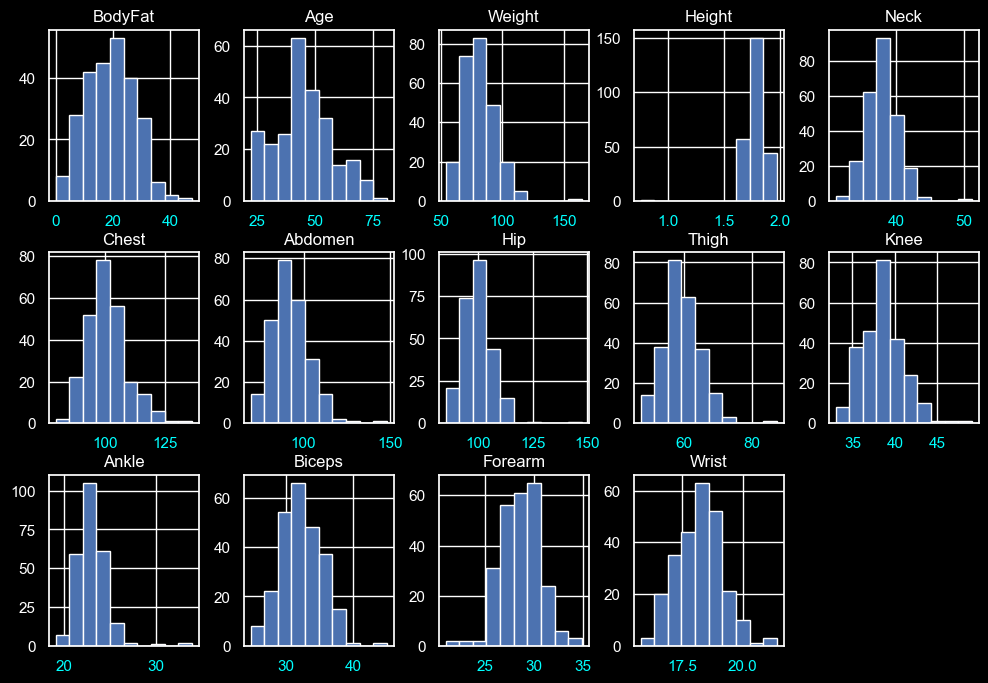

In [124]:
df.hist(figsize=(12, 8), layout=(3, 5))

En los histogramas, podemos oservar que nuestro dataset posee outliers. Para manejarlos de una manera sencilla, probemos simplemente con eliminarlos.

Utilizaremos un análisis de Z-Scoring para señalar esos outliers y luego los removeremos del dataset:

_Nota: El Z-Score es un cálculo que señala cuantas desviaciones estándar se aleja un valor de la media del dataset para ese valor_

In [125]:
from scipy import stats

# Calculamos el Z-Score para cada columna.
z_scores = stats.zscore(df)


# Definimos un umbral para identificar outliers
umbral = 2.6

# Eliminamos filas que tienen valores con un Z-Score mayor a 3 o menor a -3
df = df[(z_scores < umbral).any(axis=1)]

Como nos enfrentamos a un problema de regresión, es importante comprender si nuestras variables se relacionan de manera lineal o no. Para esto, calcularemos el coeficiente de Pearson para cada par variable de entrada - salida

<Axes: >

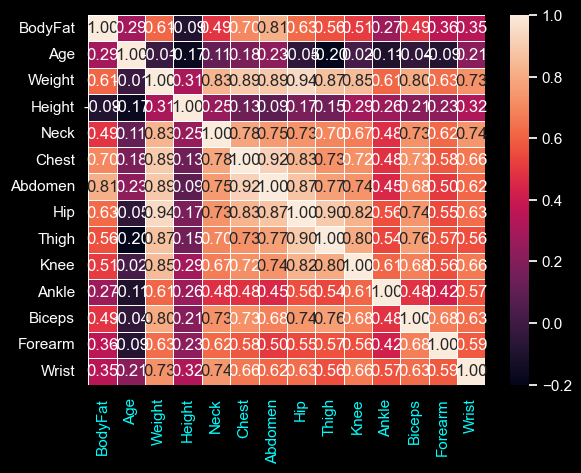

In [126]:
sns.heatmap(df.corr(), annot=True,linewidth=0.5,fmt="0.2f",cmap="rocket")

En el gráfico, podemos observar que la correlación entre algunas variables de entrada es bastante alto. Lo mejor sería filtrar las variables hasta no tener tanta intracorrelación:

In [127]:
df.drop(columns=['Height','Knee','Ankle','Wrist','Forearm'], inplace=True)

## Elección del Algoritmo

In [128]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Split de dataset
X = df.drop('BodyFat', axis=1)
y = df['BodyFat']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)


# Entrenamiento del modelo
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)


## Métricas y Resultados

In [129]:
# Métricas
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"R-squared: {r2}")
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

R-squared: 0.7768930834462903
Mean Squared Error: 18.586021460472494
Mean Absolute Error: 3.4477545753315475
Root Mean Squared Error: 4.311150827850088


## Conclusión y Reflexiones